In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [708]:
# Read in the data for processed tumor volume for each lesion:
df = pd.read_csv('processed.volumes.lesions.csv')

# Split name cases
df['Case.Patient'] = df['Case'].apply(lambda x: x.split('_')[0])

df['Case.Date'] = df['Case'].apply(lambda x: x.split('_')[1])
df['Case.Date'] = pd.to_datetime(df['Case.Date'], format='%Y%m%d')

df['Case.Scan'] = df['Case'].apply(lambda x: '_'.join(x.split('_')[2:]))

df = df.drop(columns=['Case'])

# Adapt volume to mL instead of mm^3
df['Volume'] = df['Volume'] / 1000

df = df.drop(columns=['PhysicalCoordinateSagittal', 'PhysicalCoordinateCoronal', 'PhysicalCoordinateTransverse', 'VoxelCoordinateSagittal',	
                      'VoxelCoordinateCoronal', 'VoxelCoordinateTransverse'])

start_df = df
volume_df = df
start_df

,Volume,LiverVolume,Case.Patient,Case.Date,Case.Batch,Lesion.ID,Case.Scan
0,0.001086,1857.001813,NKI-d23231-00-0067,2015-04-29,kalina11_0006,NaN,kalina11_0006
1,0.003053,1857.001813,NKI-d23231-00-0067,2015-04-29,kalina11_0006,115.0,kalina11_0006
2,0.001718,1857.001813,NKI-d23231-00-0067,2015-04-29,kalina11_0006,116.0,kalina11_0006
3,0.001144,1857.001813,NKI-d23231-00-0067,2015-04-29,kalina11_0006,NaN,kalina11_0006
4,0.004784,1857.001813,NKI-d23231-00-0067,2015-04-29,kalina11_0006,112.0,kalina11_0006
...,...,...,...,...,...,...,...
5820,0.004384,1618.564932,NKI-d23231-00-0093,2015-09-07,kalina99_0618,NaN,kalina99_0618
5821,0.032911,1333.279938,NKI-d23231-00-0075,2012-11-15,kalina99_0468,NaN,kalina99_0468
5822,0.003896,1333.279938,NKI-d23231-00-0075,2012-11-15,kalina99_0468,NaN,kalina99_0468
5823,0.001290,1333.279938,NKI-d23231-00-0075,2012-11-15,kalina99_0468,NaN,kalina99_0468


In [709]:
# Group by patient_id and find the last check-up date for each patient
last_check_up_dates = volume_df.groupby('Case.Patient')['Case.Date'].max().reset_index()
last_check_up_dates

,Case.Patient,Case.Date
0,NKI-d23231-00-0006,2013-03-19
1,NKI-d23231-00-0007,2022-02-21
2,NKI-d23231-00-0010,2007-02-13
3,NKI-d23231-00-0011,2012-11-13
4,NKI-d23231-00-0026,2008-08-28
...,...,...
96,NKI-d23231-00-0192,2007-06-19
97,NKI-d23231-00-0193,2017-12-11
98,NKI-d23231-00-0194,2009-10-01
99,NKI-d23231-00-0195,2009-10-02


In [711]:
df = df.dropna(subset=['Lesion.ID'])
df

,Volume,LiverVolume,Case.Patient,Case.Date,Case.Batch,Lesion.ID,Case.Scan
1,0.003053,1857.001813,NKI-d23231-00-0067,2015-04-29,kalina11_0006,115.0,kalina11_0006
2,0.001718,1857.001813,NKI-d23231-00-0067,2015-04-29,kalina11_0006,116.0,kalina11_0006
4,0.004784,1857.001813,NKI-d23231-00-0067,2015-04-29,kalina11_0006,112.0,kalina11_0006
6,0.013050,1857.001813,NKI-d23231-00-0067,2015-04-29,kalina11_0006,114.0,kalina11_0006
7,0.001258,1857.001813,NKI-d23231-00-0067,2015-04-29,kalina11_0006,113.0,kalina11_0006
...,...,...,...,...,...,...,...
5808,0.002149,1924.766668,NKI-d23231-00-0039,2020-03-04,kalina10_0025,35.0,kalina10_0025
5809,0.001193,1924.766668,NKI-d23231-00-0039,2020-03-04,kalina10_0025,33.0,kalina10_0025
5810,0.001854,1924.766668,NKI-d23231-00-0039,2020-03-04,kalina10_0025,34.0,kalina10_0025
5812,0.016763,1549.537354,NKI-d23231-00-0076,2009-04-23,kalina04_0048,153.0,kalina04_0048


## Total Volume Analysis


In [712]:
import numpy as np

# We dont need the coordinates at this stage, so we can remove them safely
# df = df.drop(columns=['CoordinateSagittal', 'CoordinateCoronal', 'CoordinateTransverse'])

# Compute total volume and range for each patient and date
df = df.groupby(['Lesion.ID', 'Case.Date', 'Case.Scan']).sum().reset_index()
df = df.drop(columns='Case.Scan')
df = df.groupby(['Lesion.ID', 'Case.Date']).agg(
    Volume_Mean=('Volume', 'mean'),
    Volume_Range=('Volume', lambda x: np.nan if x.size == 1 else x.max() - x.min())
).reset_index()
df = df.rename(columns={'Volume_Mean': 'Volume.Mean', 'Volume_Range': 'Volume.Range'})

df

,Lesion.ID,Case.Date,Volume.Mean,Volume.Range
0,0.0,2012-01-09,0.001920,NaN
1,0.0,2013-03-19,0.005594,NaN
2,1.0,2007-03-21,0.001318,NaN
3,1.0,2007-07-23,0.002350,NaN
4,2.0,2007-03-21,0.064645,NaN
...,...,...,...,...
1546,608.0,2009-10-01,0.002898,NaN
1547,609.0,2008-03-14,0.001332,NaN
1548,609.0,2009-10-01,0.001039,NaN
1549,610.0,2008-12-02,0.002733,NaN


## Build an interval dataset


In [713]:
# Convert Case.Date to datetime
df['Case.Date'] = pd.to_datetime(df['Case.Date'])

# Sort by Case.Patient and Case.Date
df = df.sort_values(by=['Lesion.ID', 'Case.Date'])

# Create shifted columns for pairs
df['Case.Date.End'] = df.groupby('Lesion.ID')['Case.Date'].shift(-1)
df['Volume.Mean.End'] = df.groupby('Lesion.ID')['Volume.Mean'].shift(-1)


# Rename original columns for clarity
df.rename(columns={
    'Case.Date': 'Case.Date.Start',
}, inplace=True)

# Drop rows where Case.Date.End is NaN (the last entry for each patient)
df = df.dropna(subset=['Case.Date.End'])

# Select and reorder relevant columns
# df = df[['Case.Patient', 'Case.Date.Start', 'Case.Date.End', 'Volume.Mean.Start', 'Volume.Mean.End', 'Volume.Range.Start', 'Volume.Range.End']]

df

,Lesion.ID,Case.Date.Start,Volume.Mean,Volume.Range,Case.Date.End,Volume.Mean.End
0,0.0,2012-01-09,0.001920,NaN,2013-03-19,0.005594
2,1.0,2007-03-21,0.001318,NaN,2007-07-23,0.002350
4,2.0,2007-03-21,0.064645,NaN,2007-07-23,0.001513
6,3.0,2007-03-21,0.009480,NaN,2007-07-23,0.002429
8,4.0,2007-03-21,0.006386,NaN,2007-07-23,0.006478
...,...,...,...,...,...,...
1541,606.0,2007-08-09,0.002364,NaN,2008-03-14,0.005689
1543,607.0,2008-03-14,0.001329,NaN,2009-10-01,0.004876
1545,608.0,2008-03-14,0.001697,NaN,2009-10-01,0.002898
1547,609.0,2008-03-14,0.001332,NaN,2009-10-01,0.001039


In [ ]:
# create lesion Id to track each lesion
df.insert(0, 'ID', range(1, 1 + len(df)))
anon_df = df.merge(start_df[['Case.Patient', 'Lesion.ID']], on='Lesion.ID', how='left')
df = anon_df.drop_duplicates(subset=['ID']).drop(columns=['ID'])
# an[an['Lesion.ID'] == 112]
df

,Lesion.ID,Case.Date.Start,Volume.Mean,Volume.Range,Case.Date.End,Volume.Mean.End,Case.Patient
0,0.0,2012-01-09,0.001920,NaN,2013-03-19,0.005594,NKI-d23231-00-0006
2,1.0,2007-03-21,0.001318,NaN,2007-07-23,0.002350,NKI-d23231-00-0026
4,2.0,2007-03-21,0.064645,NaN,2007-07-23,0.001513,NKI-d23231-00-0026
6,3.0,2007-03-21,0.009480,NaN,2007-07-23,0.002429,NKI-d23231-00-0026
8,4.0,2007-03-21,0.006386,NaN,2007-07-23,0.006478,NKI-d23231-00-0026
...,...,...,...,...,...,...,...
2910,606.0,2007-08-09,0.002364,NaN,2008-03-14,0.005689,NKI-d23231-00-0194
2912,607.0,2008-03-14,0.001329,NaN,2009-10-01,0.004876,NKI-d23231-00-0194
2914,608.0,2008-03-14,0.001697,NaN,2009-10-01,0.002898,NKI-d23231-00-0194
2916,609.0,2008-03-14,0.001332,NaN,2009-10-01,0.001039,NKI-d23231-00-0194


## Load Treatment data

In [715]:
# load treatment data
treatment = pd.read_excel('W_23_5814_2024-03-06.xlsx', sheet_name='Oncolytica')

# filter on the treatment of interest
treatment = treatment.loc[treatment['ATC_CODE'].apply(lambda x: str(x).startswith('L01') or str(x).startswith('L02'))]
treatment = treatment.loc[treatment['ISLAATST']]
treatment = treatment.loc[treatment['DOSERING'].apply(lambda x:'per dag 0' not in str(x))]

# select columns of interest 
treatment = treatment[['PATIENTNR', 'VOORSCHRIJFDATUM', 'VOORSCHRIJFEINDDATUM']]
treatment.rename(columns={'PATIENTNR': 'Case.Patient', 'VOORSCHRIJFDATUM': 'Treatment.Start', 'VOORSCHRIJFEINDDATUM': 'Treatment.End'}, inplace=True)

# laod surgery data
surgery = pd.read_excel('W_23_5814_2024-03-06.xlsx', sheet_name='Surgery')

# filter on the ones for the liver: *lever*, *embolisatie* 
surgery = surgery.loc[surgery['OKVR_Verrichting_omschrijving'].apply(lambda x: 'lever' in str(x).lower() or 'embolisatie' in str(x).lower() or 'rfa' in str(x).lower())]

# select columns of interest
surgery = surgery[['PATIENTNR', 'OK_Operatiedatum']]
surgery.rename(columns={'PATIENTNR': 'Case.Patient', 'OK_Operatiedatum': 'Treatment.Start'}, inplace=True)
surgery['Treatment.End'] = surgery['Treatment.Start']

# merge treatment and surgery data as intervention data
# surgery date becomes the start and end of the intervention
intervention = pd.concat([treatment, surgery], axis=0, ignore_index=True).reset_index(drop=True)

# load patient ID keys for anonymization
keys = pd.read_csv('20230926 JADS Export Report Patients.csv')

# use anonymization keys to replace patient IDs
keys = keys.loc[~(keys['Patient ID'] == '20401820xxx187484')]
keys['Patient ID'] = keys['Patient ID'].astype(int)

intervention = pd.merge(intervention, keys, left_on='Case.Patient', right_on='Patient ID', how='left')
intervention = intervention.drop(columns=['Case.Patient', 'Patient ID'])
intervention.rename(columns={'Anonymized Name': 'Case.Patient'}, inplace=True)

intervention

,Treatment.Start,Treatment.End,Case.Patient
0,2012-04-23,2012-05-01,NKI-d23231-00-0148
1,2022-07-21,2022-07-22,NKI-d23231-00-0227
2,2022-07-21,2022-07-22,NKI-d23231-00-0227
3,2022-08-04,2022-08-05,NKI-d23231-00-0227
4,2022-08-04,2022-08-05,NKI-d23231-00-0227
...,...,...,...
2040,2023-08-02,2023-08-02,NKI-d23231-00-0271
2041,2023-08-02,2023-08-02,NKI-d23231-00-0271
2042,2013-08-19,2013-08-19,NKI-d23231-00-0080
2043,2018-11-16,2018-11-16,NKI-d23231-00-0771


## add treatment interval indicator

In [716]:
# Convert Case.Date.Start and Case.Date.End to datetime
df['Case.Date.Start'] = pd.to_datetime(df['Case.Date.Start'])
df['Case.Date.End'] = pd.to_datetime(df['Case.Date.End'])

# Convert Treatment.Start and Treatment.End to datetime
intervention['Treatment.Start'] = pd.to_datetime(intervention['Treatment.Start'])
intervention['Treatment.End'] = pd.to_datetime(intervention['Treatment.End'])

# Function to check if treatment interval overlaps with case interval
def check_overlap(row, treatment_df):
    patient = row['Case.Patient']
    start = row['Case.Date.Start']
    end = row['Case.Date.End']
    treatment_intervals = treatment_df[treatment_df['Case.Patient'] == patient]
    for _, treatment in treatment_intervals.iterrows():
        if (treatment['Treatment.Start'] <= end) and (treatment['Treatment.End'] >= start):
            return True
    return False

# Apply the function to each row in df to create the indicator column
df['Treatment.Indicator'] = df.apply(lambda row: check_overlap(row, intervention), axis=1)

df

,Lesion.ID,Case.Date.Start,Volume.Mean,Volume.Range,Case.Date.End,Volume.Mean.End,Case.Patient,Treatment.Indicator
0,0.0,2012-01-09,0.001920,NaN,2013-03-19,0.005594,NKI-d23231-00-0006,False
2,1.0,2007-03-21,0.001318,NaN,2007-07-23,0.002350,NKI-d23231-00-0026,False
4,2.0,2007-03-21,0.064645,NaN,2007-07-23,0.001513,NKI-d23231-00-0026,False
6,3.0,2007-03-21,0.009480,NaN,2007-07-23,0.002429,NKI-d23231-00-0026,False
8,4.0,2007-03-21,0.006386,NaN,2007-07-23,0.006478,NKI-d23231-00-0026,False
...,...,...,...,...,...,...,...,...
2910,606.0,2007-08-09,0.002364,NaN,2008-03-14,0.005689,NKI-d23231-00-0194,False
2912,607.0,2008-03-14,0.001329,NaN,2009-10-01,0.004876,NKI-d23231-00-0194,False
2914,608.0,2008-03-14,0.001697,NaN,2009-10-01,0.002898,NKI-d23231-00-0194,False
2916,609.0,2008-03-14,0.001332,NaN,2009-10-01,0.001039,NKI-d23231-00-0194,False


## Filter lesions on Non-treatment vs Treatment Interval

In [721]:
dfnotreatment =  df[df['Treatment.Indicator'] == False]
dfnotreatment = dfnotreatment.drop(columns=['Treatment.Indicator'])
dfnotreatment


,Lesion.ID,Case.Date.Start,Volume.Mean,Volume.Range,Case.Date.End,Volume.Mean.End,Case.Patient
0,0.0,2012-01-09,0.001920,NaN,2013-03-19,0.005594,NKI-d23231-00-0006
2,1.0,2007-03-21,0.001318,NaN,2007-07-23,0.002350,NKI-d23231-00-0026
4,2.0,2007-03-21,0.064645,NaN,2007-07-23,0.001513,NKI-d23231-00-0026
6,3.0,2007-03-21,0.009480,NaN,2007-07-23,0.002429,NKI-d23231-00-0026
8,4.0,2007-03-21,0.006386,NaN,2007-07-23,0.006478,NKI-d23231-00-0026
...,...,...,...,...,...,...,...
2910,606.0,2007-08-09,0.002364,NaN,2008-03-14,0.005689,NKI-d23231-00-0194
2912,607.0,2008-03-14,0.001329,NaN,2009-10-01,0.004876,NKI-d23231-00-0194
2914,608.0,2008-03-14,0.001697,NaN,2009-10-01,0.002898,NKI-d23231-00-0194
2916,609.0,2008-03-14,0.001332,NaN,2009-10-01,0.001039,NKI-d23231-00-0194


In [722]:
dftreatment =  df[(df['Treatment.Indicator'] == True)]
dftreatment = dftreatment.drop(columns=['Treatment.Indicator'])
dftreatment

,Lesion.ID,Case.Date.Start,Volume.Mean,Volume.Range,Case.Date.End,Volume.Mean.End,Case.Patient
24,12.0,2014-08-12,0.001097,NaN,2015-04-15,0.003898,NKI-d23231-00-0034
26,13.0,2014-08-12,0.002512,NaN,2015-04-15,0.002035,NKI-d23231-00-0034
28,14.0,2016-03-09,0.002115,NaN,2016-05-15,0.001726,NKI-d23231-00-0038
30,15.0,2016-03-09,0.005185,NaN,2016-05-15,0.002271,NKI-d23231-00-0038
32,16.0,2016-03-09,0.003890,NaN,2016-05-15,0.001050,NKI-d23231-00-0038
...,...,...,...,...,...,...,...
2718,567.0,2014-07-01,0.030711,NaN,2014-10-10,0.035635,NKI-d23231-00-0186
2720,568.0,2014-07-01,0.005860,NaN,2014-10-10,0.022657,NKI-d23231-00-0186
2722,569.0,2014-07-01,0.006609,NaN,2014-10-10,0.026188,NKI-d23231-00-0186
2724,570.0,2014-07-01,0.004189,NaN,2014-10-10,0.002469,NKI-d23231-00-0186


## Ensuring Continuity of Treatment Periods in Patient Data

### No treatment period

In [723]:
df = pd.DataFrame(dfnotreatment)
df['Case.Date.Start'] = pd.to_datetime(df['Case.Date.Start'])
df['Case.Date.End'] = pd.to_datetime(df['Case.Date.End'])

# Find missing end dates and add them as new rows ensuring continuity
new_rows = []

for group_id in df['Lesion.ID'].unique():
    group_df = df[df['Lesion.ID'] == group_id]
    end_dates = group_df['Case.Date.End'].tolist()
    start_dates = group_df['Case.Date.Start'].tolist()
    
    for end_date in end_dates:
        if end_date not in start_dates:
            volume_end = group_df[group_df['Case.Date.End'] == end_date]['Volume.Mean.End'].values[0]
            new_row = {
                'Case.Date.Start': end_date,
                'Case.Date.End': pd.NaT,  # No end date for the new row
                'Volume.Mean.Start': volume_end,
                'Volume.Mean.End': pd.NaT,  # No volume end for the new row
                'Lesion.ID': group_id
            }
            new_rows.append(new_row)

# Append new rows to the original DataFrame using pd.concat
new_rows_df = pd.DataFrame(new_rows)
df = pd.concat([df, new_rows_df], ignore_index=True)

# Sort the DataFrame by Group.ID and Start Date
dfnt = df.sort_values(by=['Lesion.ID', 'Case.Date.Start']).reset_index(drop=True)

dfnt

,Lesion.ID,Case.Date.Start,Volume.Mean,Volume.Range,Case.Date.End,Volume.Mean.End,Case.Patient,Volume.Mean.Start
0,0.0,2012-01-09,0.001920,NaN,2013-03-19,0.005594,NKI-d23231-00-0006,NaN
1,0.0,2013-03-19,NaN,NaN,NaT,NaT,NaN,0.005594
2,1.0,2007-03-21,0.001318,NaN,2007-07-23,0.00235,NKI-d23231-00-0026,NaN
3,1.0,2007-07-23,NaN,NaN,NaT,NaT,NaN,0.002350
4,2.0,2007-03-21,0.064645,NaN,2007-07-23,0.001513,NKI-d23231-00-0026,NaN
...,...,...,...,...,...,...,...,...
1373,608.0,2009-10-01,NaN,NaN,NaT,NaT,NaN,0.002898
1374,609.0,2008-03-14,0.001332,NaN,2009-10-01,0.001039,NKI-d23231-00-0194,NaN
1375,609.0,2009-10-01,NaN,NaN,NaT,NaT,NaN,0.001039
1376,610.0,2008-12-02,0.002733,NaN,2009-10-02,0.001179,NKI-d23231-00-0195,NaN


In [724]:
final_dfnotreatment = dfnt[['Lesion.ID', 'Case.Date.Start','Volume.Mean','Volume.Mean.Start']]
final_dfnotreatment['volume_combined'] = final_dfnotreatment['Volume.Mean'].combine_first(final_dfnotreatment['Volume.Mean.Start'])
final_dfnotreatment.drop(columns=['Volume.Mean', 'Volume.Mean.Start'], inplace=True)
final_dfnotreatment

C:\Users\p.mugisha\AppData\Local\Temp\ipykernel_6244\3082921201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dfnotreatment['volume_combined'] = final_dfnotreatment['Volume.Mean'].combine_first(final_dfnotreatment['Volume.Mean.Start'])
C:\Users\p.mugisha\AppData\Local\Temp\ipykernel_6244\3082921201.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dfnotreatment.drop(columns=['Volume.Mean', 'Volume.Mean.Start'], inplace=True)


,Lesion.ID,Case.Date.Start,volume_combined
0,0.0,2012-01-09,0.001920
1,0.0,2013-03-19,0.005594
2,1.0,2007-03-21,0.001318
3,1.0,2007-07-23,0.002350
4,2.0,2007-03-21,0.064645
...,...,...,...
1373,608.0,2009-10-01,0.002898
1374,609.0,2008-03-14,0.001332
1375,609.0,2009-10-01,0.001039
1376,610.0,2008-12-02,0.002733


### Convert to CSV

In [725]:
#This csv file will be used in R for the 'tumgr' library
final_dfnotreatment.to_csv('grouped_lesions_nt.csv', index=False)

### Treatment period

In [726]:
df = pd.DataFrame(dftreatment)
df['Case.Date.Start'] = pd.to_datetime(df['Case.Date.Start'])
df['Case.Date.End'] = pd.to_datetime(df['Case.Date.End'])

# Find missing end dates and add them as new rows ensuring continuity
new_rows = []

for group_id in df['Lesion.ID'].unique():
    group_df = df[df['Lesion.ID'] == group_id]
    end_dates = group_df['Case.Date.End'].tolist()
    start_dates = group_df['Case.Date.Start'].tolist()
    
    for end_date in end_dates:
        if end_date not in start_dates:
            volume_end = group_df[group_df['Case.Date.End'] == end_date]['Volume.Mean.End'].values[0]
            new_row = {
                'Case.Date.Start': end_date,
                'Case.Date.End': pd.NaT,  # No end date for the new row
                'Volume.Mean.Start': volume_end,
                'Volume.Mean.End': pd.NaT,  # No volume end for the new row
                'Lesion.ID': group_id
            }
            new_rows.append(new_row)

# Append new rows to the original DataFrame using pd.concat
new_rows_df = pd.DataFrame(new_rows)
df = pd.concat([df, new_rows_df], ignore_index=True)

# Sort the DataFrame by Group.ID and Start Date
dft = df.sort_values(by=['Lesion.ID', 'Case.Date.Start']).reset_index(drop=True)

dft

,Lesion.ID,Case.Date.Start,Volume.Mean,Volume.Range,Case.Date.End,Volume.Mean.End,Case.Patient,Volume.Mean.Start
0,12.0,2014-08-12,0.001097,NaN,2015-04-15,0.003898,NKI-d23231-00-0034,NaN
1,12.0,2015-04-15,NaN,NaN,NaT,NaT,NaN,0.003898
2,13.0,2014-08-12,0.002512,NaN,2015-04-15,0.002035,NKI-d23231-00-0034,NaN
3,13.0,2015-04-15,NaN,NaN,NaT,NaT,NaN,0.002035
4,14.0,2016-03-09,0.002115,NaN,2016-05-15,0.001726,NKI-d23231-00-0038,NaN
...,...,...,...,...,...,...,...,...
187,569.0,2014-10-10,NaN,NaN,NaT,NaT,NaN,0.026188
188,570.0,2014-07-01,0.004189,NaN,2014-10-10,0.002469,NKI-d23231-00-0186,NaN
189,570.0,2014-10-10,NaN,NaN,NaT,NaT,NaN,0.002469
190,571.0,2014-07-01,0.011711,NaN,2014-10-10,0.020972,NKI-d23231-00-0186,NaN


In [727]:
final_dftreatment = dft[['Lesion.ID', 'Case.Date.Start','Volume.Mean','Volume.Mean.Start']]
final_dftreatment['volume_combined'] = final_dftreatment['Volume.Mean'].combine_first(final_dftreatment['Volume.Mean.Start'])
final_dftreatment.drop(columns=['Volume.Mean', 'Volume.Mean.Start'], inplace=True)
final_dftreatment

C:\Users\p.mugisha\AppData\Local\Temp\ipykernel_6244\1152596296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dftreatment['volume_combined'] = final_dftreatment['Volume.Mean'].combine_first(final_dftreatment['Volume.Mean.Start'])
C:\Users\p.mugisha\AppData\Local\Temp\ipykernel_6244\1152596296.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dftreatment.drop(columns=['Volume.Mean', 'Volume.Mean.Start'], inplace=True)


,Lesion.ID,Case.Date.Start,volume_combined
0,12.0,2014-08-12,0.001097
1,12.0,2015-04-15,0.003898
2,13.0,2014-08-12,0.002512
3,13.0,2015-04-15,0.002035
4,14.0,2016-03-09,0.002115
...,...,...,...
187,569.0,2014-10-10,0.026188
188,570.0,2014-07-01,0.004189
189,570.0,2014-10-10,0.002469
190,571.0,2014-07-01,0.011711


In [728]:
#This csv file will be used in R for the 'tumgr' library
final_dftreatment.to_csv('grouped_lesions_t_interval.csv', index=False)

## Tumor Grades

In [730]:
# Reading in tumor-grades data from the Tumor sheet data
tumordata = pd.read_excel('W_23_5814_2024-03-06.xlsx', sheet_name='Tumor')
tumorgrades = tumordata[['PATIENTNR', 'TRTU_Morfologie_oms']]

# # use anonymization keys to replace patient IDs
keys = keys.loc[~(keys['Patient ID'] == '20401820xxx187484')]
keys['Patient ID'] = keys['Patient ID'].astype(int)
tumorgrades = pd.merge(tumorgrades, keys, left_on='PATIENTNR', right_on='Patient ID', how='left')
tumorgrades = tumorgrades.drop(columns=['PATIENTNR', 'Patient ID'])
tumorgrades.rename(columns={'Anonymized Name': 'Case.Patient'}, inplace=True)

# Split the morfologie column into 'type' and 'tumorgrade'
tumorgrades[['type', 'tumorgrade']] = tumorgrades['TRTU_Morfologie_oms'].str.split(', ', expand=True)

# Drop the original 'full_name' column if you no longer need it
tumorgrades.drop(columns=['TRTU_Morfologie_oms'], inplace=True)
tumorgrades

,Case.Patient,type,tumorgrade
0,NKI-d23231-00-0002,Neuro-endocriene tumor,graad 1 ...
1,NKI-d23231-00-0854,Neuro-endocriene tumor,graad 1 ...
2,NKI-d23231-00-0840,Neuro-endocriene tumor,graad 1 ...
3,NKI-d23231-00-0001,Neuro-endocriene tumor,graad 1 ...
4,NKI-d23231-00-0003,Neuro-endocrien carcinoom,NNO ...
...,...,...,...
890,NKI-d23231-00-0861,Neuro-endocriene tumor,graad 1 ...
891,NKI-d23231-00-0860,Neuro-endocriene tumor,graad 2 ...
892,NKI-d23231-00-0859,Neuro-endocriene tumor,graad 1 ...
893,NKI-d23231-00-0858,Neuro-endocriene tumor,graad 2 ...


# Growth rates Max, Mean and Range G

In [731]:
tumorgrowth = pd.read_csv('results_lesions_nt.csv')
# tumorgrowth = tumorgrowth[(tumorgrowth['d'].isna()) & (tumorgrowth['phi'].isna())]
tumorgrowth = tumorgrowth.dropna(subset=['g'])
tumorgrowth

,name,N,type,selectedFit,g,d,phi
0,0,2,included,gx,0.002453,NaN,NaN
1,1,2,included,gx,0.004627,NaN,NaN
2,10,2,included,gx,0.001794,NaN,NaN
5,102,2,included,gx,0.000764,NaN,NaN
8,105,2,included,gx,0.005069,NaN,NaN
...,...,...,...,...,...,...,...
536,93,2,included,gx,0.003133,NaN,NaN
537,96,2,included,gx,0.004024,NaN,NaN
538,97,3,included,gx,0.001063,NaN,NaN
539,98,2,included,gx,0.000201,NaN,NaN


In [732]:
max_value_index = tumorgrowth['g'].idxmax()
# Drop the row with the maximum value
tumorgrowth = tumorgrowth.drop(index=max_value_index)
tumorgrowth

,name,N,type,selectedFit,g,d,phi
0,0,2,included,gx,0.002453,NaN,NaN
1,1,2,included,gx,0.004627,NaN,NaN
2,10,2,included,gx,0.001794,NaN,NaN
5,102,2,included,gx,0.000764,NaN,NaN
8,105,2,included,gx,0.005069,NaN,NaN
...,...,...,...,...,...,...,...
536,93,2,included,gx,0.003133,NaN,NaN
537,96,2,included,gx,0.004024,NaN,NaN
538,97,3,included,gx,0.001063,NaN,NaN
539,98,2,included,gx,0.000201,NaN,NaN


c:\Users\p.mugisha\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


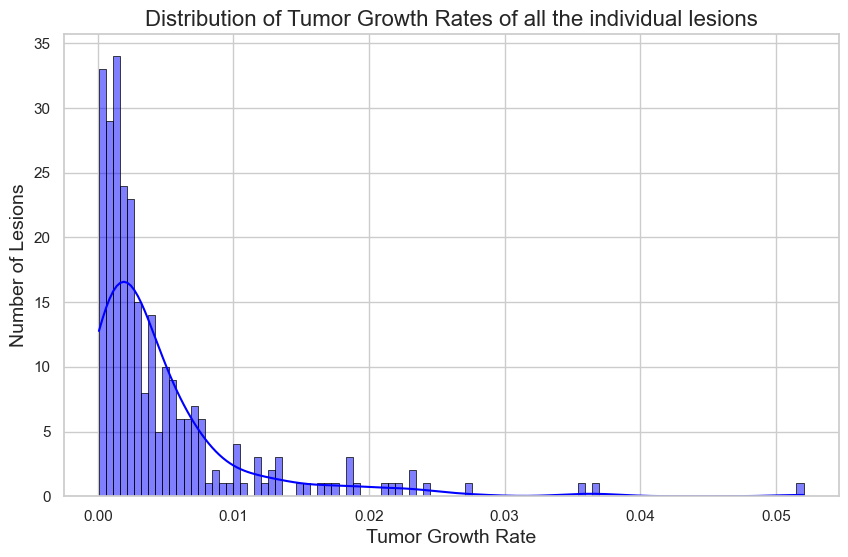

In [733]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a histogram with Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(tumorgrowth['g'], bins=100, kde=True, color='blue', edgecolor='black')

# Adding title and labels
plt.title('Distribution of Tumor Growth Rates of all the individual lesions', fontsize=16)
plt.xlabel('Tumor Growth Rate', fontsize=14)
plt.ylabel('Number of Lesions', fontsize=14)

# Show plot
plt.show()

In [734]:
growthrates = dfnotreatment[['Case.Patient', 'Lesion.ID']].merge(tumorgrowth, left_on='Lesion.ID', right_on='name', how='left')
growthrates = growthrates.drop(columns=['name', 'N', 'type', 'selectedFit']).dropna(subset=['g'])
# growthrates = growthrates.groupby('Lesion.ID')[['g', 'd', 'phi']].mean().reset_index()

# #merging growthrates with the grades
gandgrade = growthrates.merge(tumorgrades[['Case.Patient', 'tumorgrade']], on='Case.Patient', how='left')
gandgrade = gandgrade.drop_duplicates(subset=['Lesion.ID'])
# Remove white space from the 'Category' column
gandgrade['tumorgrade'] = gandgrade['tumorgrade'].str.strip()
gandgrade1 = gandgrade
gandgrade1['tumorgrade'] = gandgrade1['tumorgrade'].replace({'NNO': 'graad 3'})
gandgrade['tumorgrade'] = gandgrade['tumorgrade'].replace({'NNO': 'graad 3'})
gandgrade

,Case.Patient,Lesion.ID,g,d,phi,tumorgrade
0,NKI-d23231-00-0006,0.0,0.002453,NaN,NaN,graad 3
1,NKI-d23231-00-0026,1.0,0.004627,NaN,NaN,graad 1
2,NKI-d23231-00-0026,5.0,0.004994,NaN,NaN,graad 1
3,NKI-d23231-00-0026,7.0,0.003114,NaN,NaN,graad 1
4,NKI-d23231-00-0026,10.0,0.001794,NaN,NaN,graad 1
...,...,...,...,...,...,...
432,NKI-d23231-00-0194,604.0,0.003725,NaN,NaN,graad 1
434,NKI-d23231-00-0194,605.0,0.007598,NaN,NaN,graad 1
435,NKI-d23231-00-0194,606.0,0.004010,NaN,NaN,graad 1
436,NKI-d23231-00-0194,607.0,0.002293,NaN,NaN,graad 1


In [735]:
# aggregate the dataset in order to get max growth, mean growth and range growth
agg_df = gandgrade.groupby(['Case.Patient'])['g'].agg(
    max_g='max',
    mean_g='mean',
    range_g=lambda x: x.max() - x.min()
).reset_index()

gandgrade = gandgrade[['Case.Patient', 'tumorgrade']].merge(agg_df, on=['Case.Patient'])
gandgrade.drop_duplicates(subset=['Case.Patient'], inplace=True)
gandgrade2 = gandgrade
gandgrade

,Case.Patient,tumorgrade,max_g,mean_g,range_g
0,NKI-d23231-00-0006,graad 3,0.002453,0.002453,0.000000
1,NKI-d23231-00-0026,graad 1,0.004994,0.003632,0.003200
5,NKI-d23231-00-0039,graad 2,0.016937,0.005162,0.016519
15,NKI-d23231-00-0046,graad 1,0.001965,0.001965,0.000000
16,NKI-d23231-00-0048,graad 1,0.000812,0.000569,0.000486
18,NKI-d23231-00-0053,graad 1,0.001409,0.001386,0.000047
20,NKI-d23231-00-0054,graad 1,0.024503,0.012606,0.020928
28,NKI-d23231-00-0055,graad 3,0.000727,0.000727,0.000000
29,NKI-d23231-00-0056,graad 1,0.011579,0.011579,0.000000
30,NKI-d23231-00-0057,graad 1,0.005168,0.003669,0.002998


## Validation: Mean, Max, Rangw Growth Rates merged with date diagnosis and 'end date'

In [736]:
tumordata = pd.read_excel('W_23_5814_2024-03-06.xlsx', sheet_name='Tumor')
tumorgrades = tumordata[['PATIENTNR', 'Date_diagnosis (Stefano)', 'HiX_Date_of_death', 'TRTU_Laatste_follow_up_datum'
,'TRTU_Patientstatus_bij_laatste_follow_up_oms']]
tumorgrades['overleden'] = tumorgrades['TRTU_Patientstatus_bij_laatste_follow_up_oms'].str.contains('overleden', case=False, na=False)

# # use anonymization keys to replace patient IDs
keys = keys.loc[~(keys['Patient ID'] == '20401820xxx187484')]
keys['Patient ID'] = keys['Patient ID'].astype(int)
tumorgrades = pd.merge(tumorgrades, keys, left_on='PATIENTNR', right_on='Patient ID', how='left')
tumorgrades = tumorgrades.drop(columns=['PATIENTNR', 'Patient ID'])
tumorgrades.rename(columns={'Anonymized Name': 'Case.Patient'}, inplace=True)

# Drop the original 'full_name' column if you no longer need it
# tumorgrades.drop(columns=['TRTU_Morfologie_oms'], inplace=True)
gradesdeath = gandgrade.merge(tumorgrades, on='Case.Patient')
gradesdeath = gradesdeath.merge(last_check_up_dates, on='Case.Patient')
gradesdeath['end_date'] = gradesdeath['HiX_Date_of_death'].combine_first(gradesdeath['TRTU_Laatste_follow_up_datum'])
gradesdeath['end_date'] = gradesdeath['end_date'].combine_first(gradesdeath['Case.Date'])
gradesdeath

C:\Users\p.mugisha\AppData\Local\Temp\ipykernel_6244\739050975.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumorgrades['overleden'] = tumorgrades['TRTU_Patientstatus_bij_laatste_follow_up_oms'].str.contains('overleden', case=False, na=False)


,Case.Patient,tumorgrade,max_g,mean_g,range_g,Date_diagnosis (Stefano),HiX_Date_of_death,TRTU_Laatste_follow_up_datum,TRTU_Patientstatus_bij_laatste_follow_up_oms,overleden,Case.Date,end_date
0,NKI-d23231-00-0006,graad 3,0.002453,0.002453,0.000000,2008-12-02,NaT,2009-09-07,in leven,False,2013-03-19,2009-09-07
1,NKI-d23231-00-0026,graad 1,0.004994,0.003632,0.003200,2001-05-09,2010-12-02,2010-12-02,overleden,True,2008-08-28,2010-12-02
2,NKI-d23231-00-0039,graad 2,0.016937,0.005162,0.016519,2015-09-29,NaT,2016-07-19,in leven,False,2023-01-30,2016-07-19
3,NKI-d23231-00-0046,graad 1,0.001965,0.001965,0.000000,2008-06-05,2020-09-10,2020-09-10,overleden,True,2020-08-04,2020-09-10
4,NKI-d23231-00-0048,graad 1,0.000812,0.000569,0.000486,2001-08-02,NaT,2022-08-18,in leven,False,2020-05-22,2022-08-18
5,NKI-d23231-00-0053,graad 1,0.001409,0.001386,0.000047,2001-01-08,NaT,2022-12-22,in leven,False,2023-06-22,2022-12-22
6,NKI-d23231-00-0054,graad 1,0.024503,0.012606,0.020928,1999-05-25,2016-12-12,2016-12-12,overleden,True,2015-08-28,2016-12-12
7,NKI-d23231-00-0055,graad 3,0.000727,0.000727,0.000000,2000-09-21,2022-04-06,2022-04-06,overleden,True,2013-07-05,2022-04-06
8,NKI-d23231-00-0056,graad 1,0.011579,0.011579,0.000000,2002-06-18,2016-06-14,2016-06-14,overleden,True,2016-05-02,2016-06-14
9,NKI-d23231-00-0057,graad 1,0.005168,0.003669,0.002998,2009-07-17,2019-09-13,2019-09-13,overleden,True,2018-04-11,2019-09-13


## Correlation first g with mean g

In [737]:
# first g per patient
first_lesion_per_patient = gandgrade1.groupby('Case.Patient').first().reset_index()

#merging first g's wiht mean g's
first_and_mean_g = first_lesion_per_patient.merge(gandgrade2[['Case.Patient', 'mean_g']], on='Case.Patient')
first_and_mean_g.rename(columns={
    'g': 'first_g',
}, inplace=True)

#correlation between first g and mean g
correlation = first_and_mean_g['mean_g'].corr(first_and_mean_g['first_g'])

print("Correlation between mean_g and first_g:", correlation)
first_and_mean_g


Correlation between mean_g and first_g: 0.6703722475530909


,Case.Patient,Lesion.ID,first_g,d,phi,tumorgrade,mean_g
0,NKI-d23231-00-0006,0.0,0.002453,NaN,NaN,graad 3,0.002453
1,NKI-d23231-00-0026,1.0,0.004627,NaN,NaN,graad 1,0.003632
2,NKI-d23231-00-0039,17.0,0.016937,0.001418,NaN,graad 2,0.005162
3,NKI-d23231-00-0046,43.0,0.001965,NaN,NaN,graad 1,0.001965
4,NKI-d23231-00-0048,44.0,0.000812,NaN,NaN,graad 1,0.000569
5,NKI-d23231-00-0053,56.0,0.001409,NaN,NaN,graad 1,0.001386
6,NKI-d23231-00-0054,58.0,0.004140,NaN,NaN,graad 1,0.012606
7,NKI-d23231-00-0055,74.0,0.000727,NaN,NaN,graad 3,0.000727
8,NKI-d23231-00-0056,76.0,0.011579,NaN,NaN,graad 1,0.011579
9,NKI-d23231-00-0057,78.0,0.002170,NaN,NaN,graad 1,0.003669


## Kaplanmeier Max/Mean/range_g

[0.00499408 0.01030806 0.05204597]
Log-Rank Test between 0.005-0.010 and <= 0.005:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.87 0.35      1.52

None
Log-Rank Test between > 0.010 and <= 0.005:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.62 0.02      5.82

None


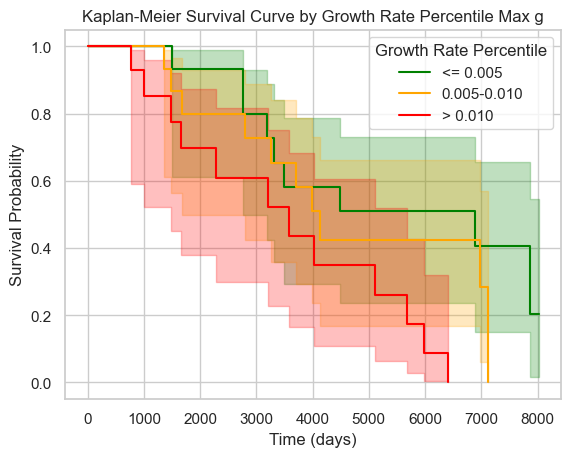


Log-Rank Test Results:
Between group 1 and group <= 0.005:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.87 0.35      1.52

None
Between group 2 and group <= 0.005:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.62 0.02      5.82

None


In [738]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import numpy as np
import matplotlib.pyplot as plt

# Assuming gradesdeath is your DataFrame
# Divide the 'max_g' column into percentiles
growth_rate_percentiles = np.percentile(gradesdeath['max_g'], [33, 66, 99], interpolation='nearest')
print(growth_rate_percentiles)

# Prepare data for Kaplan-Meier estimator for each percentile range
kmf = KaplanMeierFitter()
logrank_results = []

colors = ['green', 'orange', 'red']  # Define colors for each group

for i, percentile in enumerate(growth_rate_percentiles):
    if i == 0:
        mask = gradesdeath['max_g'] <= percentile
        label = f'<= {percentile:.3f}'
    elif i == len(growth_rate_percentiles) - 1:
        mask = gradesdeath['max_g'] > growth_rate_percentiles[i - 1]
        label = f'> {growth_rate_percentiles[i - 1]:.3f}'
    else:
        mask = (gradesdeath['max_g'] > growth_rate_percentiles[i - 1]) & (gradesdeath['max_g'] <= percentile)
        label = f'{growth_rate_percentiles[i - 1]:.3f}-{percentile:.3f}'
        
    if mask.any():  # Check if there are any data points in this range
        durations = (gradesdeath['end_date'] - gradesdeath['Date_diagnosis (Stefano)']).dt.days[mask]
        event_observed = gradesdeath['overleden'][mask]
        
        kmf.fit(durations=durations, event_observed=event_observed, label=label)
        kmf.plot(color=colors[i])
    
        # Perform log-rank test for current group compared to the first group
        if i > 0:
            result = logrank_test(durations_first_group, durations, event_observed_first_group, event_observed)
            logrank_results.append(result)
            print(f"Log-Rank Test between {label} and <= {growth_rate_percentiles[0]:.3f}:")
            print(result.print_summary())
        else:
            durations_first_group = durations
            event_observed_first_group = event_observed

# Plot settings
plt.title('Kaplan-Meier Survival Curve by Growth Rate Percentile Max g')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend(title='Growth Rate Percentile')
plt.show()

# Print the log-rank test results
print("\nLog-Rank Test Results:")
for i, result in enumerate(logrank_results):
    print(f"Between group {i+1} and group <= {growth_rate_percentiles[0]:.3f}:")
    print(result.print_summary())


[0.00499408 0.01030806 0.05204597]
Log-Rank Test between 0.005-0.010 and <= 0.005:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.87 0.35      1.52

None
Log-Rank Test between > 0.010 and <= 0.005:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.62 0.02      5.82

None
Log-Rank Test between > 0.010 and 0.005-0.010:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.13 0.08      3.70

None


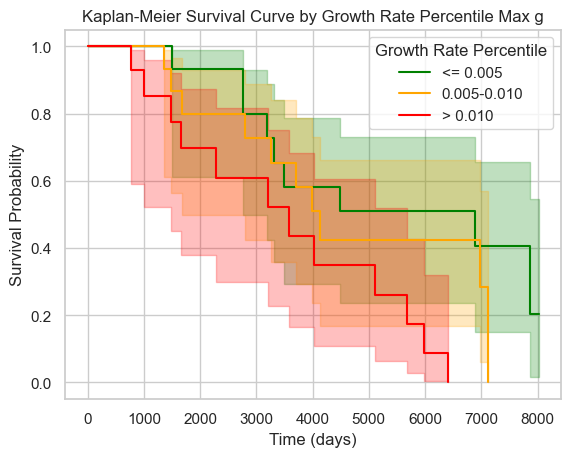


Log-Rank Test Results:
Log-Rank Test 1:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.87 0.35      1.52

None
Log-Rank Test 2:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.62 0.02      5.82

None
Log-Rank Test 3:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.13 0.08      3.70

None


In [739]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming gradesdeath is your DataFrame
# Divide the 'max_g' column into percentiles
growth_rate_percentiles = np.percentile(gradesdeath['max_g'], [33, 66, 99], interpolation='nearest')
print(growth_rate_percentiles)

# Prepare data for Kaplan-Meier estimator for each percentile range
kmf = KaplanMeierFitter()
logrank_results = []

# Initialize variables for the first and previous groups
durations_first_group = None
event_observed_first_group = None
durations_previous_group = None
event_observed_previous_group = None
label_first_group = None
label_previous_group = None

colors = ['green', 'orange', 'red']  # Define colors for each group

for i, percentile in enumerate(growth_rate_percentiles):
    if i == 0:
        mask = gradesdeath['max_g'] <= percentile
        label = f'<= {percentile:.3f}'
    elif i == len(growth_rate_percentiles) - 1:
        mask = gradesdeath['max_g'] > growth_rate_percentiles[i - 1]
        label = f'> {growth_rate_percentiles[i - 1]:.3f}'
    else:
        mask = (gradesdeath['max_g'] > growth_rate_percentiles[i - 1]) & (gradesdeath['max_g'] <= percentile)
        label = f'{growth_rate_percentiles[i - 1]:.3f}-{percentile:.3f}'
        
    if mask.any():  # Check if there are any data points in this range
        durations = (gradesdeath['end_date'] - gradesdeath['Date_diagnosis (Stefano)']).dt.days[mask]
        event_observed = gradesdeath['overleden'][mask]
        
        kmf.fit(durations=durations, event_observed=event_observed, label=label)
        kmf.plot(color=colors[i])
    
        # Perform log-rank test between current group and the first group
        if i > 0:
            if durations_first_group is not None and event_observed_first_group is not None:
                result = logrank_test(durations_first_group, durations, event_observed_first_group, event_observed)
                logrank_results.append(result)
                print(f"Log-Rank Test between {label} and {label_first_group}:")
                print(result.print_summary())
            
            # Perform log-rank test between current group and the previous group
            if durations_previous_group is not None and event_observed_previous_group is not None:
                result = logrank_test(durations_previous_group, durations, event_observed_previous_group, event_observed)
                logrank_results.append(result)
                print(f"Log-Rank Test between {label} and {label_previous_group}:")
                print(result.print_summary())
        
        # Update durations and event_observed for the first and previous groups
        if i == 0:
            durations_first_group = durations
            event_observed_first_group = event_observed
            label_first_group = label
        else:
            durations_previous_group = durations
            event_observed_previous_group = event_observed
            label_previous_group = label

# Plot settings
plt.title('Kaplan-Meier Survival Curve by Growth Rate Percentile Max g')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend(title='Growth Rate Percentile')
plt.show()

# Print the log-rank test results
print("\nLog-Rank Test Results:")
for i, result in enumerate(logrank_results):
    print(f"Log-Rank Test {i+1}:")
    print(result.print_summary())

[0.00499408 0.01030806 0.05204597]
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                      test_statistic    p  -log2(p)
0.005-0.010 <= 0.005            0.87 0.35      1.52
            > 0.010             3.13 0.08      3.70
<= 0.005    > 0.010             5.62 0.02      5.82


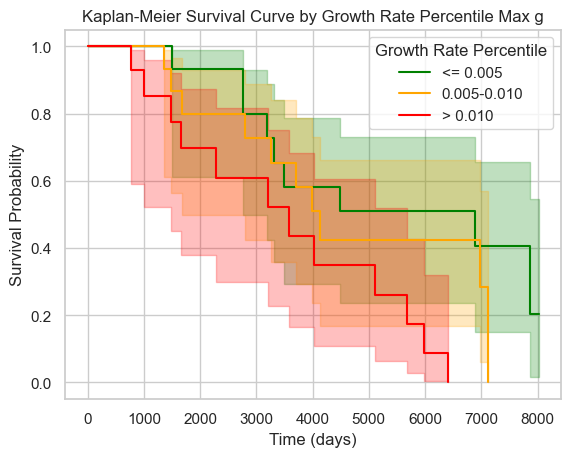

In [740]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming gradesdeath is your DataFrame
# Divide the 'max_g' column into percentiles
growth_rate_percentiles = np.percentile(gradesdeath['max_g'], [33, 66, 99], interpolation='nearest')
print(growth_rate_percentiles)

# Prepare data for Kaplan-Meier estimator for each percentile range
kmf = KaplanMeierFitter()

# Collect all durations and event observations
all_durations = []
all_event_observed = []
all_labels = []

colors = ['green', 'orange', 'red']  # Define colors for each group

for i, percentile in enumerate(growth_rate_percentiles):
    if i == 0:
        mask = gradesdeath['max_g'] <= percentile
        label = f'<= {percentile:.3f}'
    elif i == len(growth_rate_percentiles) - 1:
        mask = gradesdeath['max_g'] > growth_rate_percentiles[i - 1]
        label = f'> {growth_rate_percentiles[i - 1]:.3f}'
    else:
        mask = (gradesdeath['max_g'] > growth_rate_percentiles[i - 1]) & (gradesdeath['max_g'] <= percentile)
        label = f'{growth_rate_percentiles[i - 1]:.3f}-{percentile:.3f}'
        
    if mask.any():  # Check if there are any data points in this range
        durations = (gradesdeath['end_date'] - gradesdeath['Date_diagnosis (Stefano)']).dt.days[mask]
        event_observed = gradesdeath['overleden'][mask]
        
        kmf.fit(durations=durations, event_observed=event_observed, label=label)
        kmf.plot(color=colors[i])
        
        # Collect data for pairwise log-rank test
        all_durations.extend(durations)
        all_event_observed.extend(event_observed)
        all_labels.extend([label] * len(durations))

# Convert collected data to pandas Series
all_durations = pd.Series(all_durations)
all_event_observed = pd.Series(all_event_observed)
all_labels = pd.Series(all_labels)

# Perform pairwise log-rank test
results = pairwise_logrank_test(all_durations, all_labels, event_observed=all_event_observed)
print(results)

# Plot settings
plt.title('Kaplan-Meier Survival Curve by Growth Rate Percentile Max g')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend(title='Growth Rate Percentile')
plt.show()


[0.00120255 0.00711714 0.0507728 ]
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                      test_statistic    p  -log2(p)
0.001-0.007 <= 0.001            0.28 0.60      0.75
            > 0.007             2.83 0.09      3.43
<= 0.001    > 0.007             0.57 0.45      1.15


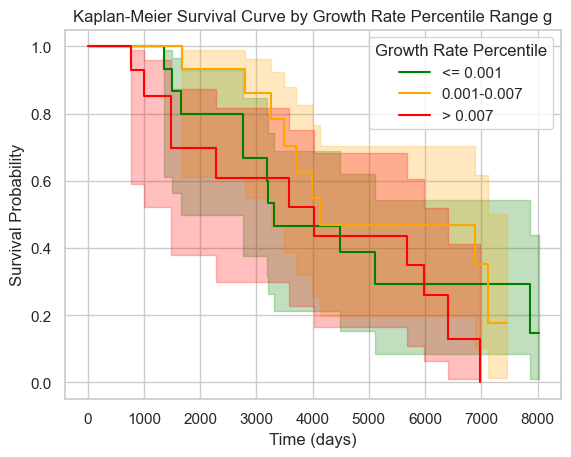

In [741]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming gradesdeath is your DataFrame
# Divide the 'range_g' column into percentiles
growth_rate_percentiles = np.percentile(gradesdeath['range_g'], [33, 66, 99], interpolation='nearest')
print(growth_rate_percentiles)

# Prepare data for Kaplan-Meier estimator for each percentile range
kmf = KaplanMeierFitter()

# Collect all durations and event observations
all_durations = []
all_event_observed = []
all_labels = []

colors = ['green', 'orange', 'red']  # Define colors for each group

for i, percentile in enumerate(growth_rate_percentiles):
    if i == 0:
        mask = gradesdeath['range_g'] <= percentile
        label = f'<= {percentile:.3f}'
    elif i == len(growth_rate_percentiles) - 1:
        mask = gradesdeath['range_g'] > growth_rate_percentiles[i - 1]
        label = f'> {growth_rate_percentiles[i - 1]:.3f}'
    else:
        mask = (gradesdeath['range_g'] > growth_rate_percentiles[i - 1]) & (gradesdeath['range_g'] <= percentile)
        label = f'{growth_rate_percentiles[i - 1]:.3f}-{percentile:.3f}'
        
    if mask.any():  # Check if there are any data points in this range
        durations = (gradesdeath['end_date'] - gradesdeath['Date_diagnosis (Stefano)']).dt.days[mask]
        event_observed = gradesdeath['overleden'][mask]
        
        kmf.fit(durations=durations, event_observed=event_observed, label=label)
        kmf.plot(color=colors[i])
        
        # Collect data for pairwise log-rank test
        all_durations.extend(durations)
        all_event_observed.extend(event_observed)
        all_labels.extend([label] * len(durations))

# Convert collected data to pandas Series
all_durations = pd.Series(all_durations)
all_event_observed = pd.Series(all_event_observed)
all_labels = pd.Series(all_labels)

# Perform pairwise log-rank test
results = pairwise_logrank_test(all_durations, all_labels, event_observed=all_event_observed)
print(results)

# Plot settings
plt.title('Kaplan-Meier Survival Curve by Growth Rate Percentile Range g')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend(title='Growth Rate Percentile')
plt.show()


[0.00245262 0.00451216 0.01708752]


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                      test_statistic      p  -log2(p)
0.002-0.005 <= 0.002            5.29   0.02      5.54
            > 0.005             1.76   0.18      2.44
<= 0.002    > 0.005            11.71 <0.005     10.65


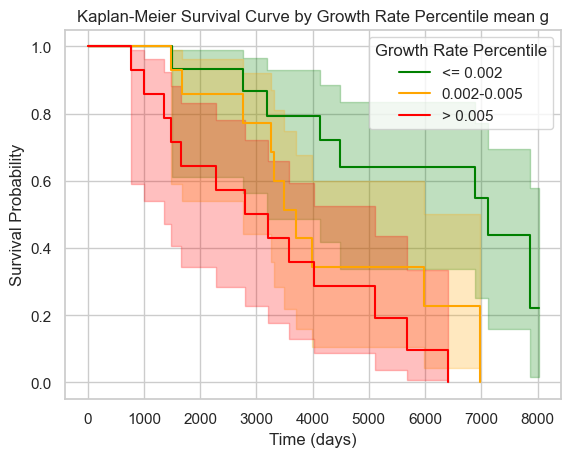

In [743]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming gradesdeath is your DataFrame
gradesdeath['HiX_Date_of_death'].fillna(pd.Timestamp.now(), inplace=True)  # Replace NaN with current date for patients who are still alive

# Divide the 'mean_g' column into percentiles
growth_rate_percentiles = np.percentile(gradesdeath['mean_g'], [33, 66, 99], interpolation='nearest')
print(growth_rate_percentiles)

# Prepare data for Kaplan-Meier estimator for each percentile range
kmf = KaplanMeierFitter()

# Collect all durations and event observations
all_durations = []
all_event_observed = []
all_labels = []

colors = ['green', 'orange', 'red']  # Define colors for each group
for i, percentile in enumerate(growth_rate_percentiles):
    if i == 0:
        mask = gradesdeath['mean_g'] <= percentile
        label = f'<= {percentile:.3f}'
    elif i == len(growth_rate_percentiles) - 1:
        mask = gradesdeath['mean_g'] > growth_rate_percentiles[i - 1]
        label = f'> {growth_rate_percentiles[i - 1]:.3f}'
    else:
        mask = (gradesdeath['mean_g'] > growth_rate_percentiles[i - 1]) & (gradesdeath['mean_g'] <= percentile)
        label = f'{growth_rate_percentiles[i - 1]:.3f}-{percentile:.3f}'
        
    if mask.any():  # Check if there are any data points in this range
        durations = (gradesdeath['end_date'] - gradesdeath['Date_diagnosis (Stefano)']).dt.days[mask]
        event_observed = gradesdeath['overleden'][mask]
        
        kmf.fit(durations=durations, event_observed=event_observed, label=label)
        kmf.plot(color=colors[i])
    
        # Collect data for pairwise log-rank test
        all_durations.extend(durations)
        all_event_observed.extend(event_observed)
        all_labels.extend([label] * len(durations))

# Convert collected data to pandas Series
all_durations = pd.Series(all_durations)
all_event_observed = pd.Series(all_event_observed)
all_labels = pd.Series(all_labels)

# Perform pairwise log-rank test
results = pairwise_logrank_test(all_durations, all_labels, event_observed=all_event_observed)
print(results)

# Plot settings
plt.title('Kaplan-Meier Survival Curve by Growth Rate Percentile mean g')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend(title='Growth Rate Percentile')
plt.show()


# Growth rates vs Grades no treatment

In [745]:
tumorgrowth = pd.read_csv('results_groupedlesions_nt.csv')
# tumorgrowth = tumorgrowth[(tumorgrowth['d'].isna()) & (tumorgrowth['phi'].isna())]
tumorgrowth = tumorgrowth.dropna(subset=['g'])
tumorgrowth

,name,N,type,selectedFit,g,d,phi
0,0,2,included,gx,0.002453,NaN,NaN
1,1,2,included,gx,0.004627,NaN,NaN
2,10,2,included,gx,0.001794,NaN,NaN
5,102,2,included,gx,0.000764,NaN,NaN
8,105,2,included,gx,0.005069,NaN,NaN
...,...,...,...,...,...,...,...
536,93,2,included,gx,0.003133,NaN,NaN
537,96,2,included,gx,0.004024,NaN,NaN
538,97,3,included,gx,0.001063,NaN,NaN
539,98,2,included,gx,0.000201,NaN,NaN


In [746]:
max_value_index = tumorgrowth['g'].idxmax()
# Drop the row with the maximum value
tumorgrowth = tumorgrowth.drop(index=max_value_index)
tumorgrowth

,name,N,type,selectedFit,g,d,phi
0,0,2,included,gx,0.002453,NaN,NaN
1,1,2,included,gx,0.004627,NaN,NaN
2,10,2,included,gx,0.001794,NaN,NaN
5,102,2,included,gx,0.000764,NaN,NaN
8,105,2,included,gx,0.005069,NaN,NaN
...,...,...,...,...,...,...,...
536,93,2,included,gx,0.003133,NaN,NaN
537,96,2,included,gx,0.004024,NaN,NaN
538,97,3,included,gx,0.001063,NaN,NaN
539,98,2,included,gx,0.000201,NaN,NaN


In [747]:
tumordata = pd.read_excel('W_23_5814_2024-03-06.xlsx', sheet_name='Tumor')
tumorgrades = tumordata[['PATIENTNR', 'TRTU_Morfologie_oms']]

# # use anonymization keys to replace patient IDs
keys = keys.loc[~(keys['Patient ID'] == '20401820xxx187484')]
keys['Patient ID'] = keys['Patient ID'].astype(int)
tumorgrades = pd.merge(tumorgrades, keys, left_on='PATIENTNR', right_on='Patient ID', how='left')
tumorgrades = tumorgrades.drop(columns=['PATIENTNR', 'Patient ID'])
tumorgrades.rename(columns={'Anonymized Name': 'Case.Patient'}, inplace=True)

# Split the morfologie column into 'type' and 'tumorgrade'
tumorgrades[['type', 'tumorgrade']] = tumorgrades['TRTU_Morfologie_oms'].str.split(', ', expand=True)

# Drop the original 'full_name' column if you no longer need it
tumorgrades.drop(columns=['TRTU_Morfologie_oms'], inplace=True)
tumorgrades

,Case.Patient,type,tumorgrade
0,NKI-d23231-00-0002,Neuro-endocriene tumor,graad 1 ...
1,NKI-d23231-00-0854,Neuro-endocriene tumor,graad 1 ...
2,NKI-d23231-00-0840,Neuro-endocriene tumor,graad 1 ...
3,NKI-d23231-00-0001,Neuro-endocriene tumor,graad 1 ...
4,NKI-d23231-00-0003,Neuro-endocrien carcinoom,NNO ...
...,...,...,...
890,NKI-d23231-00-0861,Neuro-endocriene tumor,graad 1 ...
891,NKI-d23231-00-0860,Neuro-endocriene tumor,graad 2 ...
892,NKI-d23231-00-0859,Neuro-endocriene tumor,graad 1 ...
893,NKI-d23231-00-0858,Neuro-endocriene tumor,graad 2 ...


c:\Users\p.mugisha\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


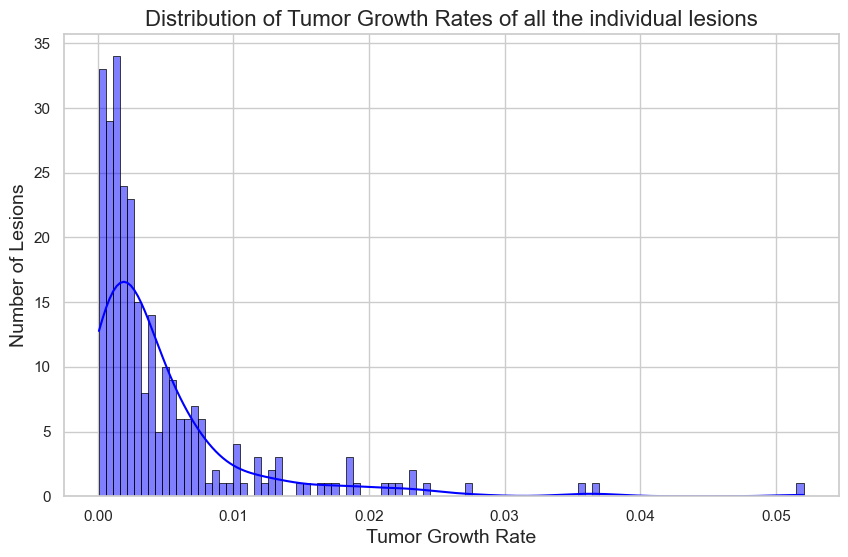

In [748]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a histogram with Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(tumorgrowth['g'], bins=100, kde=True, color='blue', edgecolor='black')

# Adding title and labels
plt.title('Distribution of Tumor Growth Rates of all the individual lesions', fontsize=16)
plt.xlabel('Tumor Growth Rate', fontsize=14)
plt.ylabel('Number of Lesions', fontsize=14)

# Show plot
plt.show()

## Growth rates merged with grades

In [749]:
growthrates = dfnotreatment[['Case.Patient', 'Lesion.ID']].merge(tumorgrowth, left_on='Lesion.ID', right_on='name', how='left')
growthrates = growthrates.drop(columns=['name', 'N', 'type', 'selectedFit']).dropna(subset=['g'])
# growthrates = growthrates.groupby('Lesion.ID')[['g', 'd', 'phi']].mean().reset_index()

# #merging growthrates with the grades
gandgrade = growthrates.merge(tumorgrades[['Case.Patient', 'tumorgrade']], on='Case.Patient', how='left')
gandgrade = gandgrade.drop_duplicates(subset=['Lesion.ID'])
# Remove white space from the 'Category' column
gandgrade['tumorgrade'] = gandgrade['tumorgrade'].str.strip()
# Replace values for graad 3
gandgrade['tumorgrade'] = gandgrade['tumorgrade'].replace({'NNO': 'graad 3'})
gandgrade


,Case.Patient,Lesion.ID,g,d,phi,tumorgrade
0,NKI-d23231-00-0006,0.0,0.002453,NaN,NaN,graad 3
1,NKI-d23231-00-0026,1.0,0.004627,NaN,NaN,graad 1
2,NKI-d23231-00-0026,5.0,0.004994,NaN,NaN,graad 1
3,NKI-d23231-00-0026,7.0,0.003114,NaN,NaN,graad 1
4,NKI-d23231-00-0026,10.0,0.001794,NaN,NaN,graad 1
...,...,...,...,...,...,...
432,NKI-d23231-00-0194,604.0,0.003725,NaN,NaN,graad 1
434,NKI-d23231-00-0194,605.0,0.007598,NaN,NaN,graad 1
435,NKI-d23231-00-0194,606.0,0.004010,NaN,NaN,graad 1
436,NKI-d23231-00-0194,607.0,0.002293,NaN,NaN,graad 1


tumorgrade
graad 1    0.004583
graad 2    0.008582
graad 3    0.003566
Name: g, dtype: float64


c:\Users\p.mugisha\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


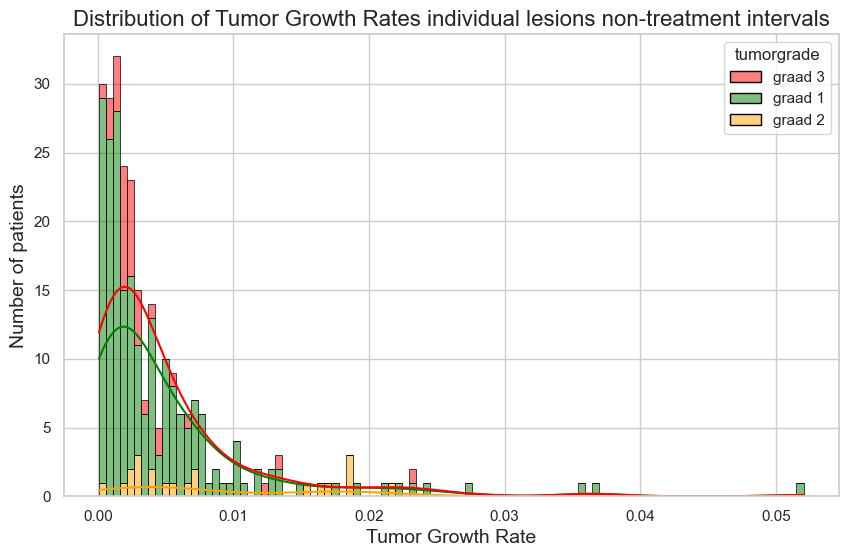

In [750]:
# Calculate mean for each group
mean_by_grade = gandgrade.groupby('tumorgrade')['g'].mean()
print(mean_by_grade)
# Set the style of the visualization
sns.set(style="whitegrid")

# Define the custom color palette
palette = {
    'graad 1': 'green',
    'graad 2': 'orange',
    'graad 3': 'red'
}

# Create a histogram with Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(
    gandgrade, 
    x='g', 
    hue='tumorgrade', 
    kde=True, 
    multiple='stack', 
    bins=100, 
    edgecolor='black', 
    palette=palette
)

# Adding title and labels
plt.title('Distribution of Tumor Growth Rates individual lesions non-treatment intervals', fontsize=16)
plt.xlabel('Tumor Growth Rate', fontsize=14)
plt.ylabel('Number of patients', fontsize=14)

# Show mean for each group
# for grade, mean in mean_by_grade.items():
#     plt.text(mean, 0, f'Mean={mean:.2f}', fontsize=10, rotation=45)

# Show plot
plt.show()

Text(0, 0.5, 'Tumor Growth Rate')

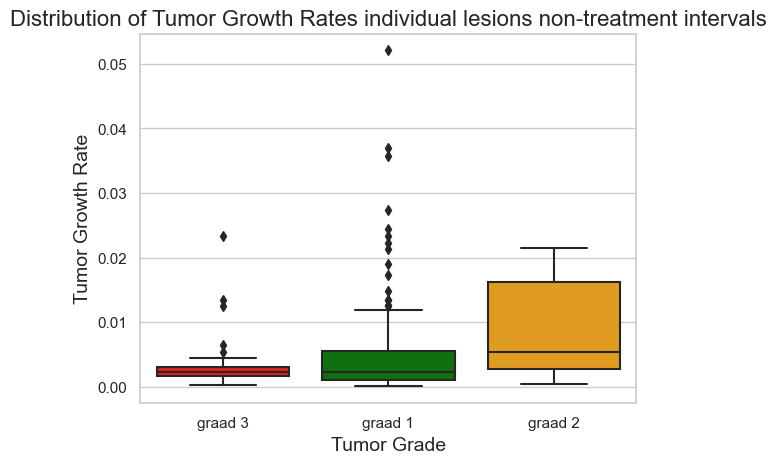

In [751]:
# Assuming 'g' is the numerical column and 'tumorgrade' is the categorical column in your DataFrame
# 'gandgrade' is your DataFrame

# Set the size of the plot
# plt.figure(figsize=(8, 6))  # Adjust the size as needed

# Create the boxplot
# custom color palette
palette = {
    'graad 1': 'green',
    'graad 2': 'orange',
    'graad 3': 'red'
}

sns.boxplot(data=gandgrade, x='tumorgrade', y='g', palette=palette)

# Adding title and labels
plt.title('Distribution of Tumor Growth Rates individual lesions non-treatment intervals', fontsize=16)
plt.xlabel('Tumor Grade', fontsize=14)
plt.ylabel('Tumor Growth Rate', fontsize=14)

# Growth rates vs Grades treatment

In [752]:
tumorgrowth = pd.read_csv('results_lesions_t.csv')
tumorgrowth.shape

(87, 7)

In [753]:
growthrates = dftreatment[['Case.Patient', 'Lesion.ID']].merge(tumorgrowth, left_on='Lesion.ID', right_on='name', how='left')
growthrates = growthrates.drop(columns=['name', 'N', 'type', 'selectedFit'])

# #merging growthrates with the grades
gandgrade = growthrates.merge(tumorgrades[['Case.Patient', 'tumorgrade']], on='Case.Patient', how='left')
gandgrade = gandgrade.drop_duplicates(subset=['Lesion.ID'])
# Remove white space from the 'Category' column
gandgrade['tumorgrade'] = gandgrade['tumorgrade'].str.strip()
# Replace values for graad 3
gandgrade['tumorgrade'] = gandgrade['tumorgrade'].replace({'NNO': 'graad 3'})
gandgrade

,Case.Patient,Lesion.ID,g,d,phi,tumorgrade
0,NKI-d23231-00-0034,12.0,0.005133,NaN,NaN,graad 1
1,NKI-d23231-00-0034,13.0,NaN,NaN,NaN,graad 1
2,NKI-d23231-00-0038,14.0,NaN,NaN,NaN,graad 2
3,NKI-d23231-00-0038,15.0,NaN,0.012128,NaN,graad 2
4,NKI-d23231-00-0038,16.0,NaN,0.019207,NaN,graad 2
...,...,...,...,...,...,...
99,NKI-d23231-00-0186,567.0,NaN,NaN,NaN,graad 2
100,NKI-d23231-00-0186,568.0,0.013258,NaN,NaN,graad 2
101,NKI-d23231-00-0186,569.0,0.013499,NaN,NaN,graad 2
102,NKI-d23231-00-0186,570.0,NaN,0.005182,NaN,graad 2


tumorgrade
graad 1    0.013791
graad 2    0.013808
Name: g, dtype: float64


c:\Users\p.mugisha\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


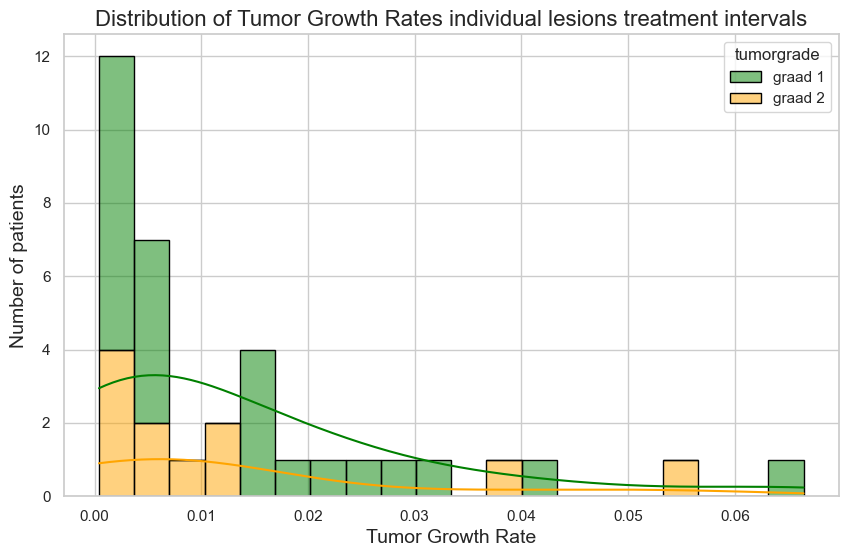

In [754]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data creation (for demonstration purposes)
# Assuming gandgrade is a DataFrame with columns 'g', 'd', and 'tumorgrade'

# Calculate mean for each group
mean_growth_by_grade = gandgrade.groupby('tumorgrade')['g'].mean()
mean_decrease_by_grade = gandgrade.groupby('tumorgrade')['d'].mean()
print(mean_growth_by_grade)

# Define the custom color palette
palette = {
    'graad 1': 'green',
    'graad 2': 'orange',
    'graad 3': 'red'
}

# Create a histogram with Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(
    gandgrade, 
    x='g', 
    hue='tumorgrade', 
    kde=True, 
    multiple='stack', 
    bins=20, 
    edgecolor='black', 
    palette=palette
)

# Adding title and labels
plt.title('Distribution of Tumor Growth Rates individual lesions treatment intervals', fontsize=16)
plt.xlabel('Tumor Growth Rate', fontsize=14)
plt.ylabel('Number of patients', fontsize=14)


plt.show()


Text(0, 0.5, 'Tumor Growth Rate')

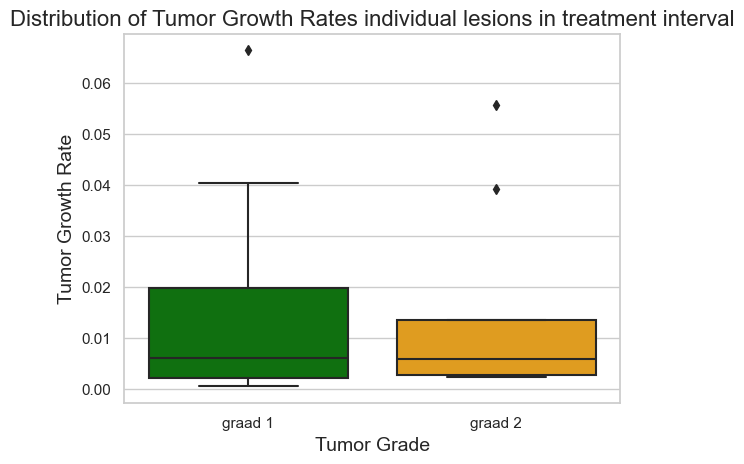

In [755]:
# Create the boxplot
sns.boxplot(data=gandgrade, x='tumorgrade', y='g', palette=palette)

# Adding title and labels
plt.title('Distribution of Tumor Growth Rates individual lesions in treatment interval', fontsize=16)
plt.xlabel('Tumor Grade', fontsize=14)
plt.ylabel('Tumor Growth Rate', fontsize=14)

tumorgrade
graad 1    0.012509
graad 2    0.010002
Name: d, dtype: float64


c:\Users\p.mugisha\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


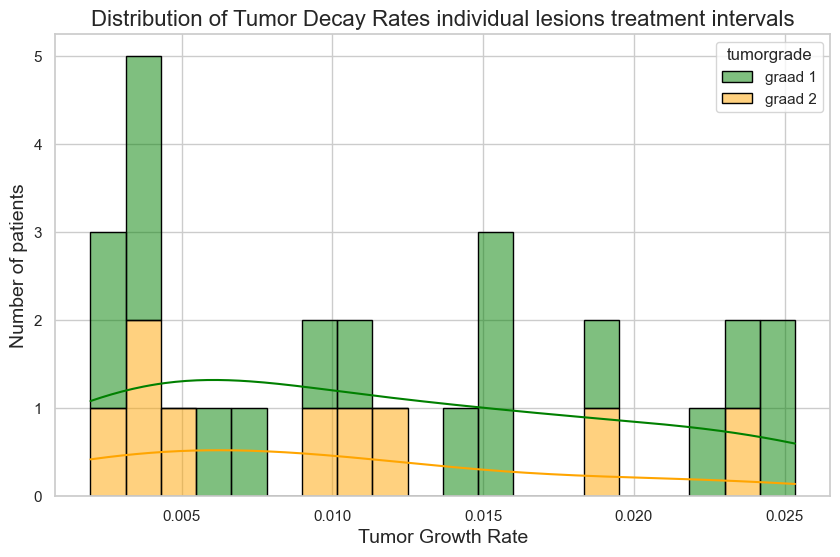

In [757]:


# Calculate mean decay for each group
mean_decrease_by_grade = gandgrade.groupby('tumorgrade')['d'].mean()
print(mean_decrease_by_grade)

# custom color palette
palette = {
    'graad 1': 'green',
    'graad 2': 'orange',
    'graad 3': 'red'
}

# Create a histogram with Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(
    gandgrade, 
    x='d', 
    hue='tumorgrade', 
    kde=True, 
    multiple='stack', 
    bins=20, 
    edgecolor='black', 
    palette=palette
)

# Adding title and labels
plt.title('Distribution of Tumor Decay Rates individual lesions treatment intervals', fontsize=16)
plt.xlabel('Tumor Growth Rate', fontsize=14)
plt.ylabel('Number of patients', fontsize=14)

plt.show()
